In [42]:
#conda install basemap
#pip install -U matplotlib==3.2
#pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import conda
#"C:\Users\parul\anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share\epsg"
os.environ['PROJ_LIB'] = r'C:\Users\parul\anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

In [21]:
import datetime, mpl_toolkits as mt, matplotlib.pyplot as plt, numpy as np, pandas as pd, time 
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [22]:
US_data = pd.read_csv("US_Data.csv")
CA_data = pd.read_csv("CA_Data.csv")

In [23]:
print(US_data.columns)
CA_data.columns

Index(['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Magnitude_Method',
       'NST', 'Azimuthal_Gap', 'D_min', 'RMS_TimeResidual', 'Type',
       'Horizontal_Error', 'Depth_Error', 'Magnitude_Error', 'Magnitude_Nst',
       'Location_Source', 'Magnitude_Source', 'Region', 'Date', 'Time'],
      dtype='object')


Index(['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Magnitude_Method',
       'NST', 'Azimuthal_Gap', 'D_min', 'RMS_TimeResidual', 'Type',
       'Horizontal_Error', 'Depth_Error', 'Magnitude_Error', 'Magnitude_Nst',
       'Location_Source', 'Magnitude_Source', 'Region', 'Date', 'Time'],
      dtype='object')

In [24]:
US_data.shape

(100892, 19)

In [25]:
data = US_data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,2023-02-27,22:58:07,19.255000,-155.437667,1.15,2.53
1,2023-02-27,17:11:05,19.451500,-155.236500,28.35,2.74
2,2023-02-27,10:34:10,20.076000,-156.165000,42.37,3.17
3,2023-02-26,07:23:43,19.176333,-155.511500,31.48,2.78
4,2023-02-25,19:36:35,19.185000,-155.621167,-0.53,2.95


Since the data is random, so we need to scale it based on the model inputs. In this, we convert the given date and time to Unix time which is in seconds and a number. This can be easily used as an entry for the network we have built:

In [26]:
timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%Y-%m-%d %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')

timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

C:\Users\parul\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.255000,-155.437667,1.15,2.53,1.677567e+09
1,19.451500,-155.236500,28.35,2.74,1.677547e+09
2,20.076000,-156.165000,42.37,3.17,1.677523e+09
3,19.176333,-155.511500,31.48,2.78,1.677425e+09
4,19.185000,-155.621167,-0.53,2.95,1.677383e+09


## Data Visualization
Now, before we create the earthquake prediction model, let’s visualize the data on a world map that shows a clear representation of where the earthquake frequency will be more:

C:\Users\parul\anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
C:\Users\parul\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


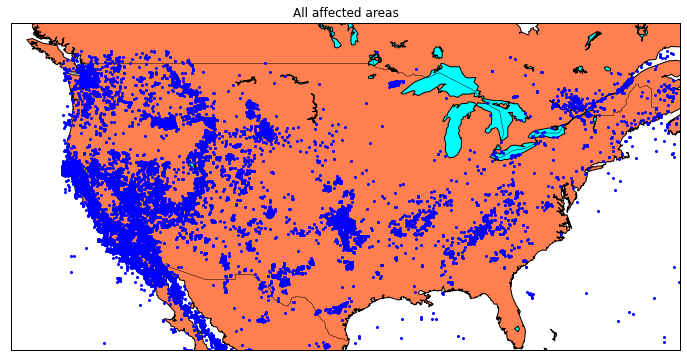

In [27]:
m = Basemap(projection='mill',llcrnrlat=25,urcrnrlat=52, llcrnrlon=-130,urcrnrlon=-65,lat_ts=20,resolution='l')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()

x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
m.bluemarble()
plt.show()

## Dataset split

In [28]:
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(80713, 3) (20179, 3) (80713, 2) (20179, 3)


## Neural Network

In [12]:
def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [14]:
model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

C:\Users\parul\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [17]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.000000 using {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
1.000000 (0.000000) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.600000 (0.489898) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
0.200000 (0.400000) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.600000 (0.489898) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}


In [18]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Epoch 1/20
8072/8072 [==============================] - 13s 2ms/step - loss: 0.6105 - accuracy: 0.7775 - val_loss: 0.6069 - val_accuracy: 0.7801
Epoch 2/20
8072/8072 [==============================] - 12s 2ms/step - loss: 0.6105 - accuracy: 0.7775 - val_loss: 0.6069 - val_accuracy: 0.7801
Epoch 3/20
8072/8072 [==============================] - 12s 1ms/step - loss: 0.6105 - accuracy: 0.7775 - val_loss: 0.6069 - val_accuracy: 0.7801
Epoch 4/20
8072/8072 [==============================] - 13s 2ms/step - loss: 0.6105 - accuracy: 0.7775 - val_loss: 0.6069 - val_accuracy: 0.7801
Epoch 5/20
8072/8072 [==============================] - 13s 2ms/step - loss: 0.6105 - accuracy: 0.7775 - val_loss: 0.6069 - val_accuracy: 0.7801
Epoch 6/20
8072/8072 [==============================] - 12s 2ms/step - loss: 0.6105 - accuracy: 0.7775 - val_loss: 0.6069 - val_accuracy: 0.7801
Epoch 7/20
8072/8072 [==============================] - 13s 2ms/step - loss: 0.6105 - accuracy: 0.7775 - val_loss: 0.6069 - val_ac

### Random Forest Regressor

In [29]:
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)
reg.predict(X_test)

array([[  2.677  ,   6.66975],
       [  2.954  ,   8.756  ],
       [  3.053  , 124.881  ],
       ...,
       [  2.845  ,  47.524  ],
       [  3.215  ,  21.864  ],
       [  2.945  ,  69.975  ]])

In [30]:
reg.score(X_test, y_test)

0.48414675579466027

In [31]:
parameters = {'n_estimators':[10, 20, 50, 100, 200, 500]}

grid_obj = GridSearchCV(reg, parameters)
grid_fit = grid_obj.fit(X_train, y_train)
best_fit = grid_fit.best_estimator_
best_fit.predict(X_test)

array([[  2.7032  ,   7.710744],
       [  2.9646  ,   8.6568  ],
       [  2.9752  , 125.9044  ],
       ...,
       [  2.8176  ,  47.7538  ],
       [  3.2784  ,  20.2618  ],
       [  2.9274  ,  69.8882  ]])

In [32]:
best_fit.score(X_test, y_test)

0.4865405678740023